# Imports

In [60]:
import tensorflow as tf
from tensorflow.keras import layers 
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import warnings

We're going to want to filter out some warnings that might get in the way due to deprecated code depending on the version of tensorflow hence the above import 

In [61]:
warnings.filterwarnings('ignore')

In [62]:
pd.set_option('display.max_rows', 6)
pd.set_option('display.max_columns', 6)
np.random.seed(2)
print(np.random.choice(5,10))

[0 0 3 2 3 0 2 1 3 2]


# Part 1: The Data
The dataset used to train this model will be the famous Cora dataset

* Nodes in Cora represet research papers with the edges representing citations between those papers


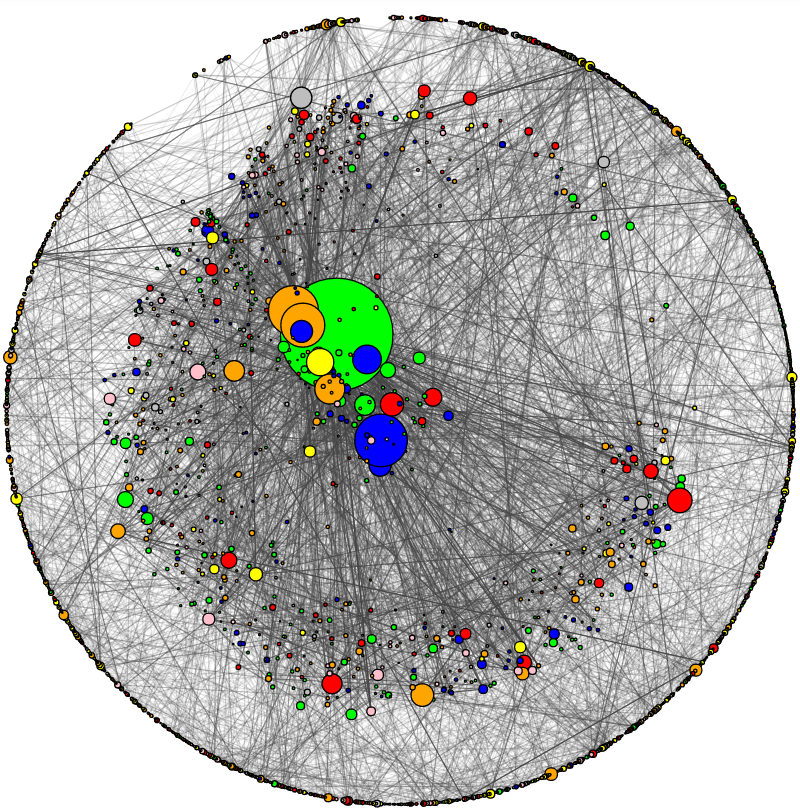

# Transductive vs Inductive Settings 

Unlike computer vision data that only utilizes `inductive` splitting of data into train and validation sets, graph data can ALSO be split through a `transductive` process
* Basically `transductive` splitting involves only using the labels of the nodes and then splitting some of the nodes (not graphs) into train / val / test datasets. 
* The key effect of doing this is that during forward propagation, the split feature vectors of the nodes will be aggregated together which in turn means that some of the features that will be used in training may come from the val or test sets
* It's important to understand that you are NOT using the label information from the val and test sets while training but you ARE using their feature vector information


In [63]:
# extract the contents of the zip file
zip_file = tf.keras.utils.get_file(
    fname="cora.tgz",
    origin="https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz",
    extract=True,
)

# place all the contents in a new directory called "cora"
data_directory = os.path.join(os.path.dirname(zip_file), 'cora')



As described earlier, each citation represents an edge in the graph and each paper is a node. There are 1433 id's that are going to be used in the data set, with each id refering to a unique paper.

Let's open these up and then print them out to make sure we can see what we're dealing with

In [64]:
# Get the papers / nodes
papers = pd.read_csv(
    os.path.join(data_directory, 'cora.content'),
    sep='\t',
    header=None,
    names=['paper_id'] + [f'term_{idx}' for idx in range(1433)] + ['subject'],
)

# Get the citations / edges
citations = pd.read_csv(
    os.path.join(data_directory, 'cora.cites'),
    sep='\t',
    header=None,
    names=['target', 'source'],
)

class_values_list = sorted(papers['subject'].unique())

# get the paper indicies
paper_index = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

# get the class id's
class_index = {name: id for id, name in enumerate(class_values_list)}


papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_index[name])
papers["subject"] = papers["subject"].apply(lambda value: class_index[value])

citations["source"] = citations["source"].apply(lambda name: paper_index[name])
citations["target"] = citations["target"].apply(lambda name: paper_index[name])

print('THESE ARE THE PAPERS:\n\n')
print(papers, '\n\n')
print('THESE ARE THE CITATIIONS:\n\n')
print(citations)


THESE ARE THE PAPERS:


      paper_id  term_0  term_1  ...  term_1431  term_1432  subject
0          462       0       0  ...          0          0        2
1         1911       0       0  ...          0          0        5
2         2002       0       0  ...          0          0        4
...        ...     ...     ...  ...        ...        ...      ...
2705      2372       0       0  ...          0          0        1
2706       955       0       0  ...          0          0        0
2707       376       0       0  ...          0          0        2

[2708 rows x 1435 columns] 


THESE ARE THE CITATIIONS:


      target  source
0          0      21
1          0     905
2          0     906
...      ...     ...
5426    1874    2586
5427    1876    1874
5428    1897    2707

[5429 rows x 2 columns]


# Split the dataset

In [65]:
# Obtain random indices 
random_indices = np.random.permutation(range(papers.shape[0]))

# iloc is an integer based indexing tool that will help us split the data
# 50/50 split (make sure to modulate by 2 since the data set total is an odd number)
train_data = papers.iloc[random_indices[: len(random_indices) // 2]]
test_data = papers.iloc[random_indices[len(random_indices) // 2:]] # from the value after train data to the end of the set

# Data Prepping 

We are going to have to get the indicies from the data so that we can use them to query the node states from the graph later on when we train the model. 

Let's also get some ground truth labels so that we can properly evaluate the trained model's predictions. 

In [66]:
# Get the indices
train_indices = train_data['paper_id'].to_numpy()
test_indices = test_data['paper_id'].to_numpy()

# Ground Truth Labels
train_labels = train_data['subject'].to_numpy()
test_labels = test_data['subject'].to_numpy()

# Define a node feature tensor and an edge tensor that will make up the graph 
edges = tf.convert_to_tensor(citations[['target', 'source']])
node_states = tf.convert_to_tensor(papers.sort_values('paper_id').iloc[:, 1: -1])

# Let's take a look at the shapes of the graph 
print('Edges shape: \n', edges.shape)
print('\nNode features shape: \n', node_states.shape)

Edges shape: 
 (5429, 2)

Node features shape: 
 (2708, 1433)


# Visualizing the Data

Let's make a function to visualize the number of input / output edges the nodes have (i.e the degree distribution or the connectedness of the graph)

In [67]:


def plot_in_out_degree_distributions(edge_index, num_of_nodes, dataset_name):
  """
    This function calculates only the degree distribution
    * It's possible to calculate many other metrics such as graph diameter, number of traingles, etc. using igraph / networkx
  """

  if isinstance(edge_index, tf.Tensor):
    edge_index = edge_index.cpu().numpy()

  assert isinstance(edge_index, np.ndarray), f'Expected NumPy array got {type(edge_index)}'

  # Store each node's input and output degree (they're the same for undirected graphs such as Cora)
  input_degrees = np.zeros(num_of_nodes, dtype=np.int)
  output_degrees = np.zeros(num_of_nodes, dtype=np.int)

  # Edge index shape = (2, E), the first row contains the source nodes, the second one contains the target nodes
  # source nodes  -> target nodes 
  num_of_edges = edge_index.shape[1]
  for cnt in range(num_of_edges):
    source_node_id = edge_index[0, cnt]
    target_node_id = edge_index[1, cnt]

    output_degrees[source_node_id] += 1 # source node points towards some other node -> increment its out degree
    input_degrees[target_node_id] += 1 # increment the input degrees

  hist = np.zeros(np.max(output_degrees) + 1)
  for out_degree in output_degrees:
    hist[out_degree] += 1

  fig = plt.figure(figsize=(12, 8), dpi=100) # otherwise plots are really small
  fig.subplots_adjust(hspace=0.6)

  plt.subplot(311)
  plt.plot(input_degrees, color='red')
  plt.xlabel('node id'); plt.ylabel('in-degree count'); plt.title('Input degree for different node ids')

  plt.subplot(312)
  plt.plot(output_degrees, color='green')
  plt.xlabel('node id'); plt.ylabel('out-degree count'); plt.title('Out degree for different node ids')

  plt.subplot(313)
  plt.plot(hist, color='blue')
  plt.xlabel('node degree')
  plt.ylabel('# nodes for a given out-degree') 
  plt.title(f'Node out-degree distribution for {dataset_name} dataset')
  plt.xticks(np.arange(0, len(hist), 5.0))

  plt.grid(True)
  plt.show()

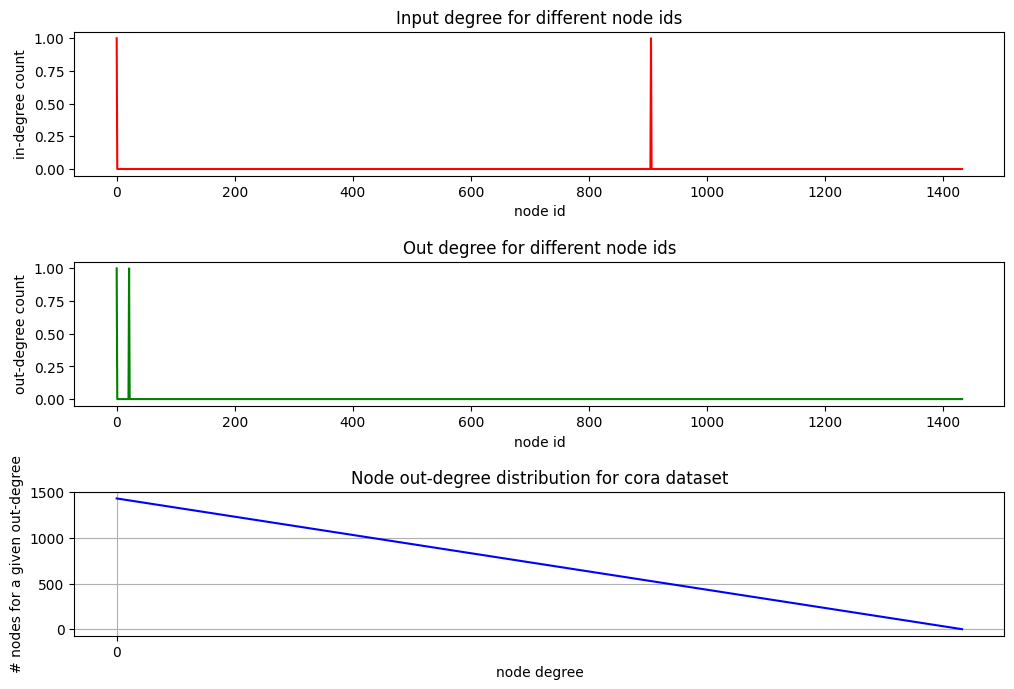

In [68]:
num_of_nodes = 1433
plot_in_out_degree_distributions(edges, num_of_nodes, dataset_name='cora')

Let's break down the graph above:
* The top two plots are the same since in this model we are treating Cora as an undirected graph
  * Note that normally it would be treated as a directed graph
* Certain nodes have a large number of edges (the peaks in the middle) but most have far fewer edges
* The third plot is responsible for visualizing this data in the form of a histogram (hence the peak on the left side) and most nodes having 2-5 edges

Here is a really cool graph [visualization tool](http://networkrepository.com/graphvis.php?d=./data/gsm50/labeled/cora.edges) you can test out that's already pre-loaded with CORA :))



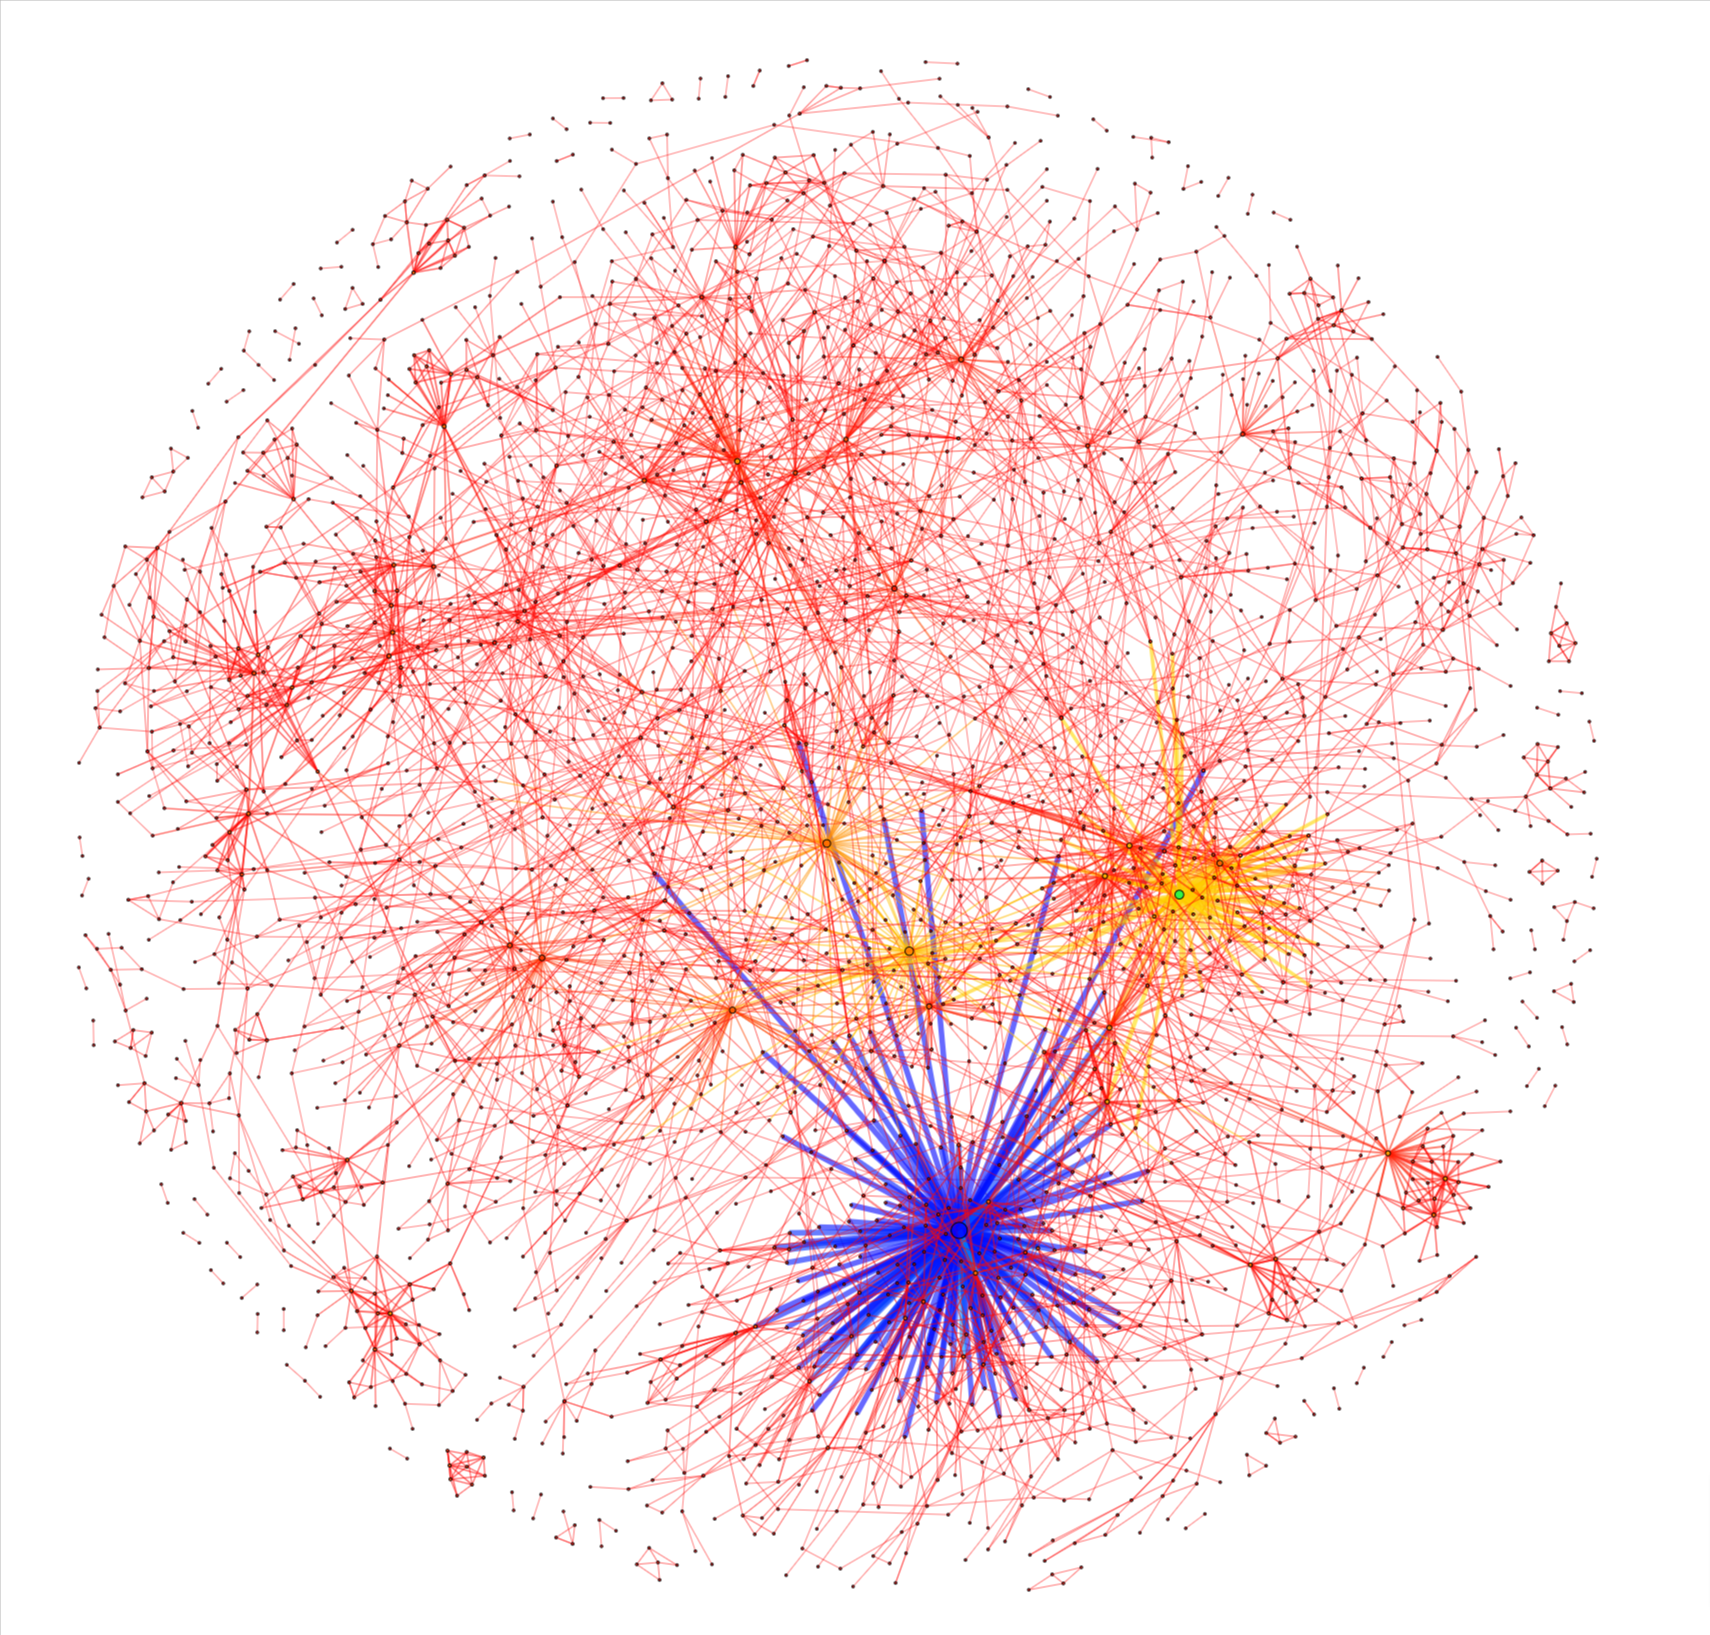

pReTTyYY WiZaRD 😎

# Part 2: Building the Model 

We are going to split the model into two main sections:
* Graph Attention
* Multi-Headed Attention Layer

This GAT is going to take in the CORA graph (the edge and node feature tensors we just created) and is going to output updated node states. For a more in depth breakdown of how this is going to work check out the README in the repo!

One key difference I would like to point out is that unlike normal GNNs, GATs implement an attention mechanism to aggregate the most import information from each of the neighboring nodes that surround the current node states. The GAT will apply normalized attention scores to each node state before summing up the information. 

# Multi-Headed Attention Layer
This layer (`MultiHeadGraphAttention`) is based off of the one described in the original paper and will simply perform a concatentation of multiple graph attention layers (`GraphAttention`). Each of these will have a seperate learnable weight that will be updated N times (where N is the number of layers in the GAT)

In [69]:
class GraphAttention(layers.Layer):
    def __init__(self, units, 
                 kernel_initializer='glorot_uniform', # initializer used in paper
                 kernel_regularizer=None, **kwargs,):
        super().__init__(**kwargs)
        self.units = units
        self.kernel_initializer = tf.keras.initializers.get(kernel_initializer)
        self.kernel_regularizer = tf.keras.regularizers.get(kernel_regularizer)


    def build(self, input_shape):

        self.kernel = self.add_weight(
            shape = (input_shape[0][-1], self.units),
            trainable = True, # gotta make sure we can actually train the layers and update the weights
            initializer = self.kernel_initializer,
            regularizer = self.kernel_regularizer,
            name = 'kernel', 
        )

        self.kernel_attention = self.add_weight(
            shape=(self.units * 2, 1),
            trainable=True,
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            name="kernel_attention",
        )

        self.built = True


    def call(self, inputs):
      node_states, edges = inputs

      # Linearly transform node states
      node_states_transformed = tf.matmul(node_states, self.kernel)

      # Computeattention scores
      node_states_expanded = tf.gather(node_states_transformed, edges)
      node_states_expanded = tf.reshape(node_states_expanded, (tf.shape(edges)[0], -1))

      # we're going to use leaky ReLU for calculating the attention scores
      # this will emphasize the most intense (i.e. important) values
      attention_scores = tf.nn.leaky_relu(tf.matmul(node_states_expanded, self.kernel_attention))
      attention_scores = tf.squeeze(attention_scores, -1)
      
      # Normalize the attention scores 
      # Use clip_by_value() to force the tensors to be between -2 and 2
      attention_scores = tf.math.exp(tf.clip_by_value(attention_scores, -2, 2))
      attention_scores_sum = tf.math.unsorted_segment_sum(
            data=attention_scores,
            segment_ids=edges[:, 0],
            num_segments=tf.reduce_max(edges[:, 0]) + 1,)
      attention_scores_sum = tf.repeat(
          attention_scores_sum, tf.math.bincount(tf.cast(edges[:, 0], dtype='int32')))

      attention_scores_norm = attention_scores / attention_scores_sum


      # Gather the node states of neighboring nodes
      # Then apply attention scores and aggregate all of it together 
      node_states_neighbors = tf.gather(node_states_transformed, edges[:, 1])
      out = tf.math.unsorted_segment_sum(
          data = node_states_neighbors * attention_scores_norm[:, tf.newaxis], 
          segment_ids = edges[:, 0],
          num_segments = tf.shape(node_states)[0])
      
      return out 


In [70]:
class MultiHeadGraphAttention(layers.Layer):
    def __init__(self, units, num_heads=8, merge_type='concat', **kwargs):
        super().__init__(**kwargs)
        self.num_heads = num_heads
        self.merge_type = merge_type
        self.attention_layers = [GraphAttention(units) for _ in range(num_heads)]

    
    def call(self, inputs):
        atom_features, pair_indices = inputs

        # Obtain outputs from each attention head
        outputs = [attention_layer([atom_features, pair_indices]) for attention_layer in self.attention_layers]
        # Concat or average the node states from each of the individual attention heads depending on the merge_type
        if self.merge_type == 'concat':
            outputs = tf.concat(outputs, axis = -1)
        else:
            outputs = tf.reduce_mean(tf.stack(outputs, axis = -1), axis = -1)

        return tf.nn.relu(outputs)
        

Next we are going to have to create a class to bring everything together along with some functions that will define our training logic

We'll have to have a custom:
* train_step
* test_step
* predict_step

It's important to note that in all three phases (training, testing, predicting) the entire graph is being used on on the model. The only difference is going to be in the use of the indices for the nodes as well as the labels 
* These will be gathered using `tf.gather(outputs, indices))`

In [71]:
class GraphAttentionModel(tf.keras.Model):
    def __init__(self, node_states, edges, hidden_units, num_heads, num_layers, output_dim, **kwargs,):

        super(). __init__(**kwargs)
        self.node_states = node_states
        self.edges = edges
        self.preprocess = layers.Dense(hidden_units * num_heads, activation='relu')
        self.attention_layers = [
            MultiHeadGraphAttention(hidden_units, num_heads) for _ in range(num_layers)
        ]
        self.output_layer = layers.Dense(output_dim)


    def call(self, inputs): 
        node_states, edges = inputs
        x = self.preprocess(node_states)

        for attention_layer in self.attention_layers:
            x = attention_layer([x, edges]) + x

        outputs = self.output_layer(x)
        return outputs
 
    
    def train_step(self, data):
        indices, labels = data

        # We're going to need to automatically keep track of the operations and be able to differentiate 
        # Use tf.GradientTape()
        with tf.GradientTape() as tape:
            
            # Forward
            outputs = self([self.node_states, self.edges])

            # Calculate the loss
            loss = self.compiled_loss(labels, tf.gather(outputs, indices))

        # Calculate gradients
        grads = tape.gradient(loss, self.trainable_weights)

        # Update the weights
        optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Update the metrics 
        self.compiled_metrics.update_state(labels, tf.gather(outputs, indices))

        # return a dictionary with name and result pairs from the metrics
        return {m.name: m.result() for m in self.metrics}

    
    def predict_step(self, data):
        indices = data

        # Forward
        outputs = self([self.node_states, self.edges])

        # Return the softmax probabilities 
        return tf.nn.softmax(tf.gather(outputs, indices))


    def test_step(self, data):
        indices, labels = data

        # Forward
        outputs = self([self.node_states, self.edges])

        #  Calculate loss
        loss = self.compiled_loss(labels, tf.gather(outputs, indices))

        # Update the metrics 
        self.compiled_metrics.update_state(labels, tf.gather(outputs, indices))

        # return the same metrics as the training_step
        return {m.name: m.result() for m in self.metrics}


# Train and Test Model

In [72]:
# Define hyper-parameters
HIDDEN_UNITS = 100
NUM_HEADS = 8
NUM_LAYERS = 3
OUTPUT_DIM = len(class_values_list)

NUM_EPOCHS = 100
BATCH_SIZE = 256
VALIDATION_SPLIT = 0.1
LEARNING_RATE = 3e-1
MOMENTUM = 0.9


loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

# Use stochasitic gradient descent like they did in the orignal paper
optimizer = tf.keras.optimizers.SGD(LEARNING_RATE, momentum=MOMENTUM)

accuracy_fn = tf.keras.metrics.SparseCategoricalAccuracy(name='acc')

# I just found out this is a thing so now I don't have to constantly create custom classes to accomplish this haha
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_acc',
    min_delta=1e-5,
    patience=5,
    restore_best_weights=True)

In [73]:
# Build the model
model = GraphAttentionModel(
    node_states, 
    edges, 
    HIDDEN_UNITS, 
    NUM_HEADS, 
    NUM_LAYERS, 
    OUTPUT_DIM)

# Compile the GAT
model.compile(loss = loss_fn,
              optimizer = optimizer,
              metrics = [accuracy_fn])



# Train the GAT
model.fit(x = train_indices,
      y = train_labels, 
      validation_split = VALIDATION_SPLIT,
      batch_size = BATCH_SIZE,
      epochs = NUM_EPOCHS,
      verbose = 2,
      )


# Test the model
_, test_accuracy = model.evaluate(x = test_indices,
                                  y = test_labels, 
                                  verbose = 1)

print("--" * 38 + f"\nTest Accuracy {test_accuracy*100:.1f}%")


Epoch 1/100


KeyboardInterrupt: ignored

# Predicting probabilities

In [ ]:
test_probs = gat_model.predict(x=test_indices)

mapping = {v: k for (k, v) in class_index.items()}

for i, (probs, label) in enumerate(zip(test_probs[:10], test_labels[:10])):
    print(f"Example {i+1}: {mapping[label]}")
    for j, c in zip(probs, class_index.keys()):
        print(f"\tProbability of {c: <24} = {j*100:7.3f}%")
    print("---" * 20)